# PART 1: Data Import and Excess Return Computation
#### This part of code computes daily excess returns for global equity indices using risk-free rates and market data.

In [1]:
! pip install --upgrade yfinance

In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from matplotlib import cm

country_indices = {
    "EWT": "Taiwan",
    "SPY": "USA",
    "EWY": "South Korea",
    "EWZ": "Brazil",
    "EWW": "Mexico",
    "EWC": "Canada",
    "EWJ": "Japan",
    "EWA": "Australia",
    "EZA": "South Africa",
    "ENZL": "New Zealand",
    "THD": "Thailand",
    "EIDO": "Indonesia",
    "EPHE": "Philippines",
    "EWU": "UK",
    "EWG": "Germany",
    "EWQ": "France",
    "EWI": "Italy",
    "INDY": "India"
}

C:\Users\Asus\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
# Downloand 3 months T-bill time series
rf_data = yf.download("^IRX", start="2014-01-01", end="2023-12-31", progress=False)
rf_data["Daily_rf_Rate"] = rf_data["Close"] / 100 / 252  # Daily Rate conversion
rf_data = rf_data[["Daily_rf_Rate"]].dropna()

print(f"Risk-free rate time series:")
print(rf_data.tail(15))

Risk-free rate time series:
Price      Daily_rf_Rate
Ticker                  
Date                    
2023-12-08      0.000208
2023-12-11      0.000208
2023-12-12      0.000208
2023-12-13      0.000207
2023-12-14      0.000207
2023-12-15      0.000207
2023-12-18      0.000207
2023-12-19      0.000208
2023-12-20      0.000208
2023-12-21      0.000207
2023-12-22      0.000207
2023-12-26      0.000206
2023-12-27      0.000208
2023-12-28      0.000207
2023-12-29      0.000206


In [4]:
def fetch_excess_returns(symbol, rf_series):
    """
    Fetch financial data for a given symbol, calculate returns, and compute excess returns.

    :param symbol: The stock or index ticker symbol (e.g., "AAPL", "SPY").
    :param rf_series: A pandas Series representing the daily risk-free rate.
    :return: A pandas DataFrame containing the excess returns for the specified symbol.
    """
    data = yf.download(symbol, start="2014-01-01", end="2023-12-31", progress=False)
    data["Return"] = data["Close"].pct_change()
    data["Excess_Return"] = data["Return"] - rf_data["Daily_rf_Rate"]
    return data[["Excess_Return"]]

#START: Code created by AI

# Combine data
country_data = pd.concat(
    [fetch_excess_returns(symbol, rf_data).rename(columns={"Excess_Return": symbol}) for symbol in country_indices],
    axis=1
).dropna()

print("Country Data (Excess Returns):")
country_data.tail().style.set_properties(**{'font-size': '10pt', 'text-align': 'center'})


#END: Code created by AI

Country Data (Excess Returns):


Price,EWT,SPY,EWY,EWZ,EWW,EWC,EWJ,EWA,EZA,ENZL,THD,EIDO,EPHE,EWU,EWG,EWQ,EWI,INDY
Ticker,,,,,,,,,,,,,,,,,,
Date,,,,,,,,,,,,,,,,,,
2023-12-22 00:00:00,0.003404,0.001803,-0.002546,0.008241,-0.000796,0.007260,0.002961,0.002275,-0.013763,-0.001045,0.005371,0.002067,0.005592,0.003146,-0.000884,-0.001483,0.000980,0.000410
2023-12-26 00:00:00,0.020931,0.004016,0.004483,0.015103,0.007167,0.010774,-0.000522,0.008044,0.005192,0.004616,0.006767,0.005692,-0.000591,0.004958,0.005552,0.005927,0.007201,0.002875
2023-12-27 00:00:00,0.009702,0.001600,0.008817,0.003206,0.001988,0.000878,0.005321,0.004702,0.024200,0.006470,0.006245,0.004754,-0.004437,0.003721,0.005518,0.003348,0.004204,0.009417
2023-12-28 00:00:00,0.003500,0.000171,0.017218,-0.004743,-0.007511,-0.004818,0.005762,-0.003057,-0.024749,0.006426,0.002920,-0.002451,0.005971,-0.005325,-0.006905,-0.009825,-0.006942,0.004661
2023-12-29 00:00:00,-0.000206,-0.003101,-0.007026,-0.004478,-0.001824,-0.000751,0.001356,-0.006331,0.020556,-0.001441,-0.004726,0.003843,-0.002892,-0.000206,0.000806,0.001072,0.000089,-0.006059


# PART 2: Portfolio Optimization and Visualization
#### Calculates MVP, Tangency Portfolio, Efficient Frontier, and visualizes portfolio metrics across rolling windows with significant ETFs highlighted.

In [5]:
# Parameters declaration
start_year = 2014
total_years = 10
rolling_window = 4

In [6]:
# Function to calculate the Tangency Portfolio
def calculate_tangency_portfolio(mean_returns, cov_matrix):
    """
    Calculate the tangency portfolio weights.
    :param mean_returns: Array of excess returns for assets
    :param cov_matrix: Covariance matrix of asset returns
    :return: Weights of the tangency portfolio

    """

    num_assets = len(mean_returns)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

    result = minimize(
        lambda x: -(np.dot(x, mean_returns)) / np.sqrt(np.dot(x.T, np.dot(cov_matrix, x))),
        np.ones(num_assets) / num_assets,
        method='SLSQP', bounds=[(0, 1)] * num_assets, constraints=constraints
    )
    return result.x

In [7]:
# Function to calculate the Minimum Variance Portfolio
def calculate_mvp(mean_returns, cov_matrix):
    """
    Calculate the weights for the Minimum Variance Portfolio (MVP).

    :param mean_returns: Array of mean returns for the assets.
    :param cov_matrix: Covariance matrix of asset returns.
    :return: Array of weights for the Minimum Variance Portfolio.
    """
    num_assets = len(mean_returns)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  # Sum of weights = 1
    initial_weights = np.ones(num_assets) / num_assets

    result = minimize(
        lambda x: np.sqrt(np.dot(x.T, np.dot(cov_matrix, x))),
        initial_weights, method='SLSQP', bounds=[(0, 1)] * num_assets, constraints=constraints
    )
    return result.x

In [8]:
def efficient_frontier(mean_returns, cov_matrix, mvp_return, points=100):
    """
    Calculate the efficient frontier for a portfolio of assets.

    :param mean_returns: Array of mean returns for the assets.
    :param cov_matrix: 2D array (matrix) representing the covariance of asset returns.
    :param mvp_return: The return of the Minimum Variance Portfolio (MVP), used as the starting point.
    :param points: Number of target points to calculate along the efficient frontier (default is 100).
    :return: A 2D NumPy array with two rows:
             - First row contains target returns.
             - Second row contains the corresponding portfolio risks (standard deviations).
    """

    targets = np.linspace(mvp_return, max(mean_returns), points)
    results = []

    # Iterate over target returns to find the optimal portfolio for each
    for target in targets:
        constraints = [
            {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},  # Weights sum to 1
            {'type': 'eq', 'fun': lambda x: np.dot(x, mean_returns) - target}  # Achieve target return
        ]
        result = minimize(
            lambda x: np.sqrt(np.dot(x.T, np.dot(cov_matrix, x))),  # Minimize portfolio risk
            np.ones(len(mean_returns)) / len(mean_returns),  # Equal weights
            method='SLSQP',  # Sequential Least Squares Programming optimization
            bounds=[(0, 1)] * len(mean_returns),  # Long-only portfolio weights
            constraints=constraints
        )
        if result.success:
                       results.append((target, np.sqrt(np.dot(result.x.T, np.dot(cov_matrix, result.x)))))

    return np.array(results).T


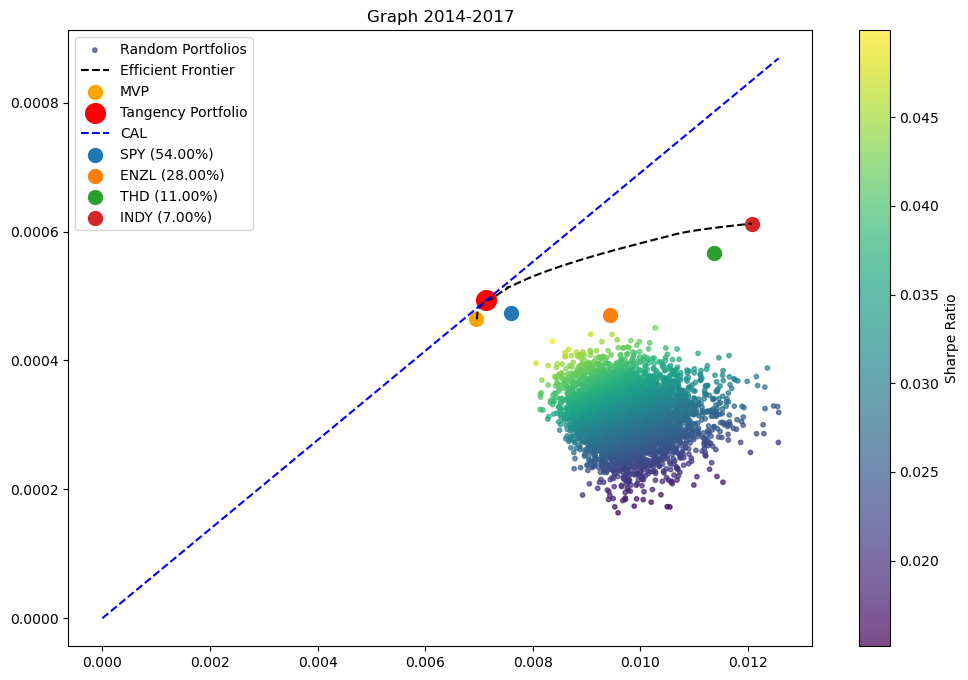

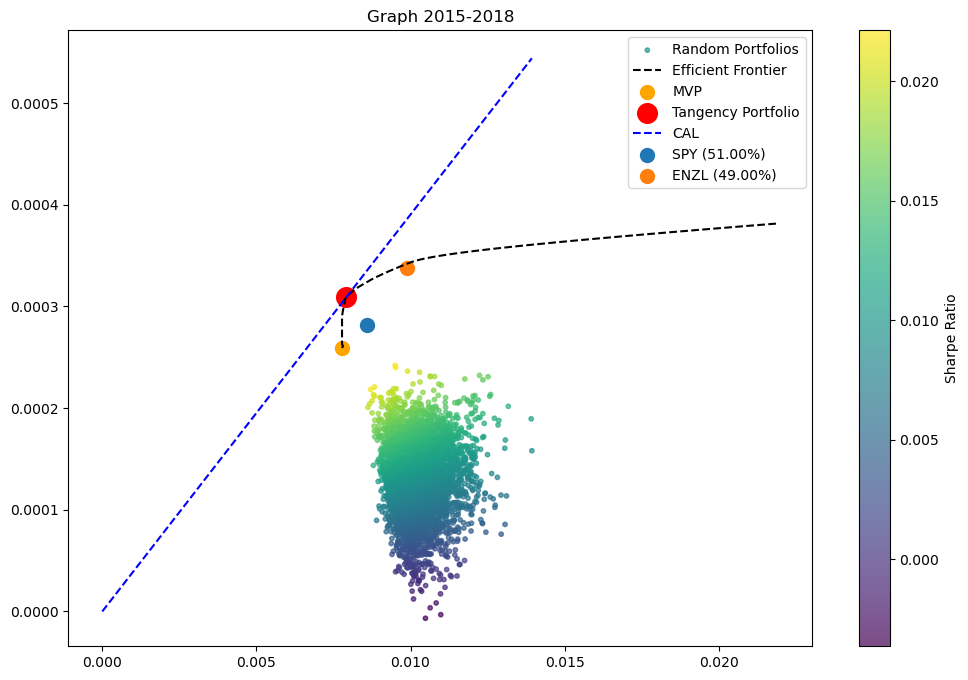

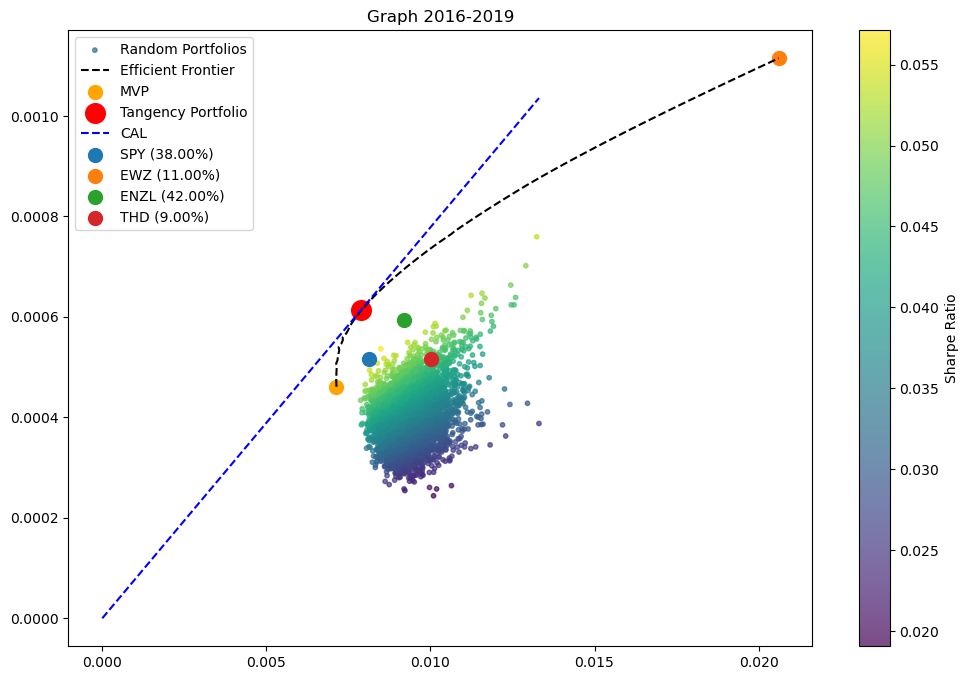

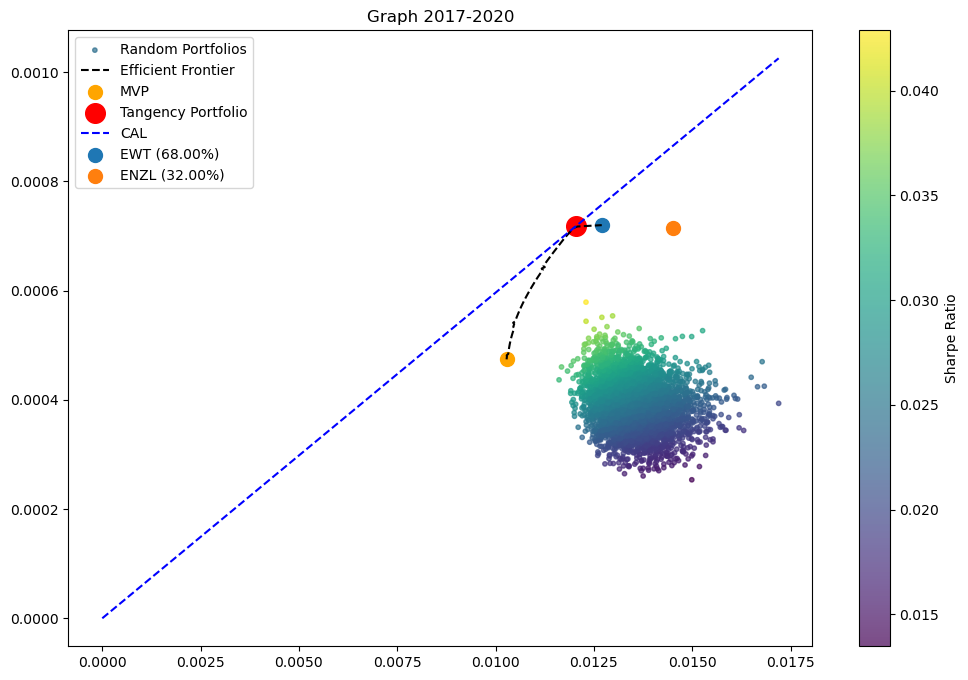

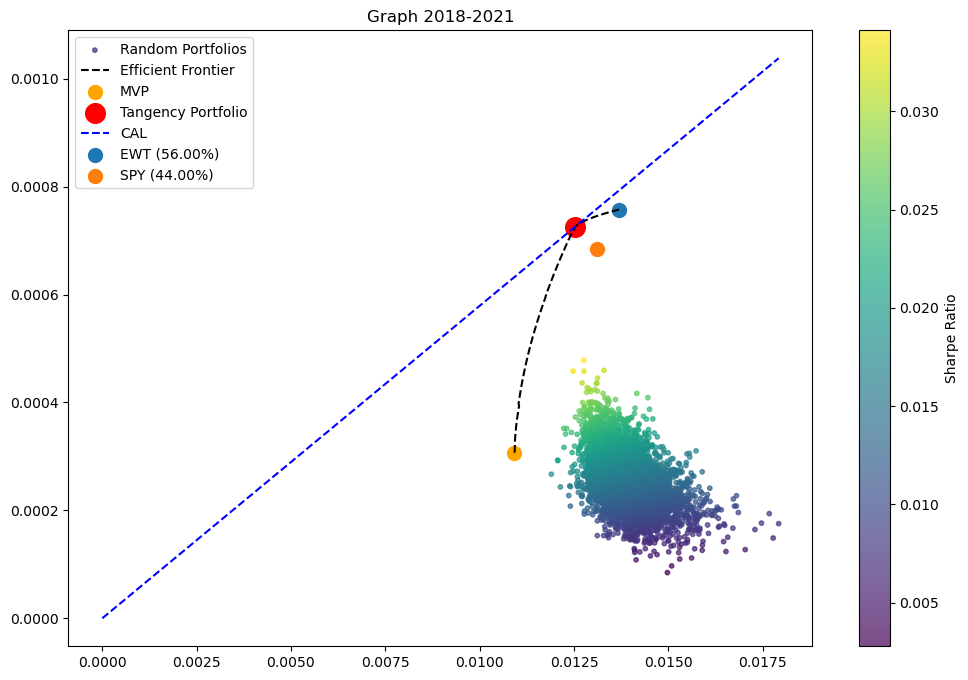

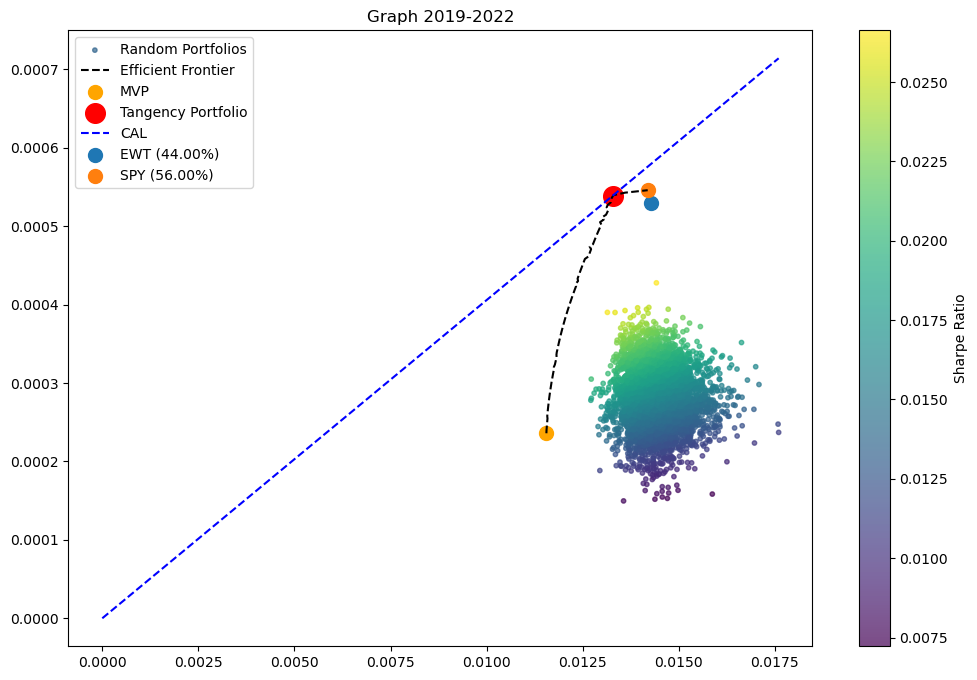

In [9]:
# Calculations for each rolling window
summary_results = []
for start in range(start_year, start_year + total_years - rolling_window):
    window_data = country_data.loc[f"{start}-01-01":f"{start + rolling_window - 1}-12-31"]
    risk_free_window = rf_data.loc[f"{start}-01-01":f"{start + rolling_window - 1}-12-31"]

    mean_returns = window_data.mean().values
    cov_matrix = window_data.cov().values
    risk_free_rate = risk_free_window["Daily_rf_Rate"].mean()

    # MVP
    mvp_weights = calculate_mvp(mean_returns, cov_matrix)
    mvp_return = np.dot(mvp_weights, mean_returns)
    mvp_risk = np.sqrt(np.dot(mvp_weights.T, np.dot(cov_matrix, mvp_weights)))

    # Tangency Portfolio
    tangency_weights = calculate_tangency_portfolio(mean_returns, cov_matrix)
    tangency_return = np.dot(tangency_weights, mean_returns)
    tangency_risk = np.sqrt(np.dot(tangency_weights.T, np.dot(cov_matrix, tangency_weights)))
    sharpe_ratio = (tangency_return) / tangency_risk

    # Efficient Frontier
    efficient_results = efficient_frontier(mean_returns, cov_matrix, mvp_return)

    # Significant ETFs
    significant_etfs = {k: round(v, 2) for k, v in zip(country_indices.keys(), tangency_weights) if v > 0.001}

    #START: Code created by AI

    # Plot
    fig, ax = plt.subplots(figsize=(12, 8))
    random_weights = np.random.dirichlet(np.ones(len(mean_returns)), size=5000)
    random_returns = np.dot(random_weights, mean_returns)
    random_risks = np.sqrt(np.einsum('ij,ij->i', np.dot(random_weights, cov_matrix), random_weights))

    scatter = ax.scatter(random_risks, random_returns, c=(random_returns - risk_free_rate) / random_risks,
                          cmap='viridis', alpha=0.7, s=10, label='Random Portfolios')
    ax.plot(efficient_results[1], efficient_results[0], 'k--', label='Efficient Frontier')
    ax.scatter(mvp_risk, mvp_return, c='orange', label='MVP', s=100)
    ax.scatter(tangency_risk, tangency_return, c='red', label='Tangency Portfolio', s=200)
    ax.plot(np.linspace(0, max(random_risks), 100),
            sharpe_ratio * np.linspace(0, max(random_risks), 100),
            'b--', label='CAL')

    for symbol, weight in significant_etfs.items():
        index = list(country_indices.keys()).index(symbol)
        ax.scatter(np.sqrt(cov_matrix[index, index]), mean_returns[index], label=f"{symbol} ({weight:.2%})", s=100)

    ax.set_title(f"Graph {start}-{start + rolling_window - 1}")
    ax.legend()
    plt.colorbar(scatter, label='Sharpe Ratio')
    plt.show()

    # Save results for summary
    summary_results.append({
        "Period": f"{start}-{start + rolling_window - 1}",
        "Sharpe Ratio": round(sharpe_ratio, 4),
        "Significant ETFs": significant_etfs
    })
    
    #END: Code created by AI
    


In [10]:
# Summary Table
print("\nSummary Table:\n")
summary_table = pd.DataFrame(summary_results)
summary_table.style.set_properties(**{'font-size': '12pt', 'text-align': 'center'})


Summary Table:



,Period,Sharpe Ratio,Significant ETFs
0,2014-2017,0.069100,"{'SPY': 0.54, 'ENZL': 0.28, 'THD': 0.11, 'INDY': 0.07}"
1,2015-2018,0.039000,"{'SPY': 0.51, 'ENZL': 0.49}"
2,2016-2019,0.077800,"{'SPY': 0.38, 'EWZ': 0.11, 'ENZL': 0.42, 'THD': 0.09}"
3,2017-2020,0.059600,"{'EWT': 0.68, 'ENZL': 0.32}"
4,2018-2021,0.057900,"{'EWT': 0.56, 'SPY': 0.44}"
5,2019-2022,0.040600,"{'EWT': 0.44, 'SPY': 0.56}"


# PART 3: Tangency Portfolio Performance Analysis
#### Analyzes cumulative returns, significant ETF weights, and Sharpe ratios over time for tangency portfolio investments.

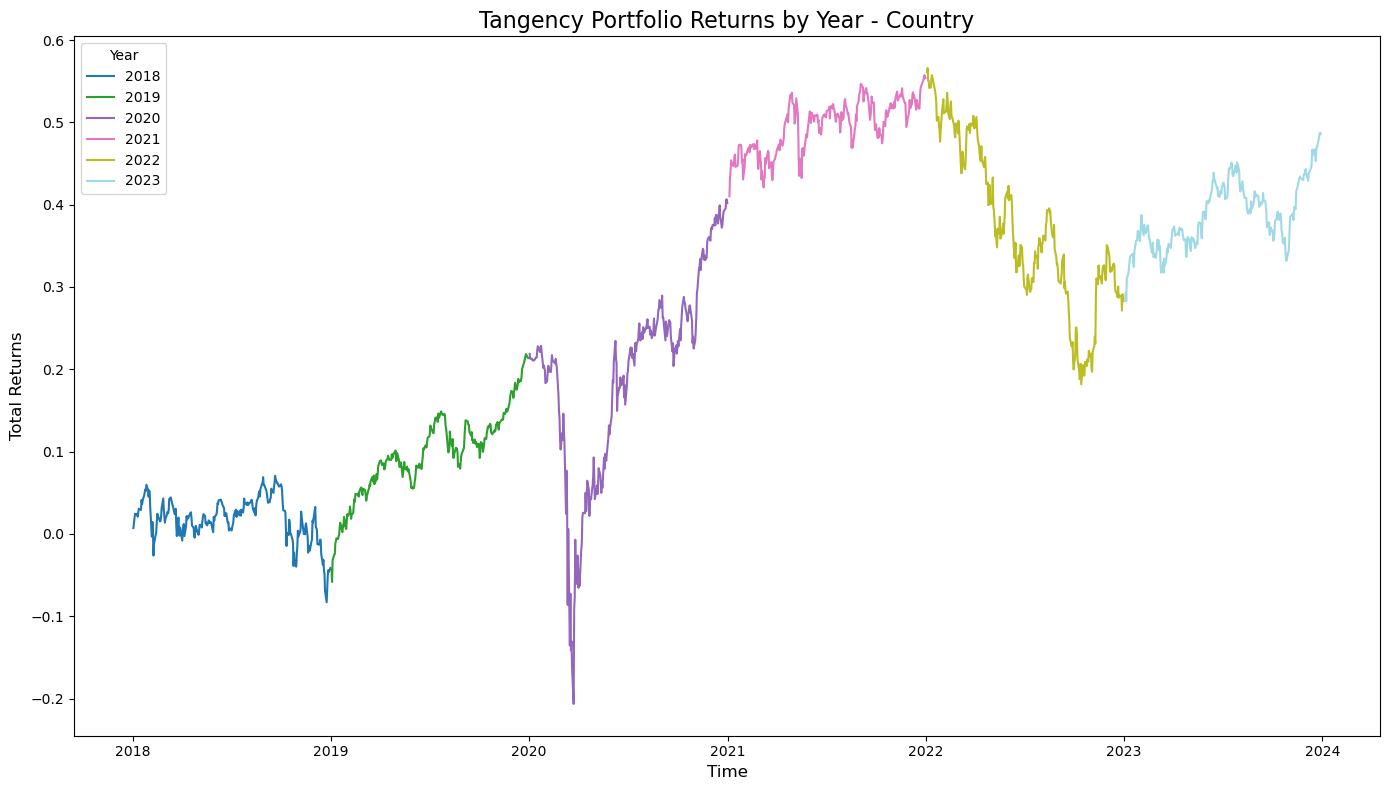

In [11]:
investment_years = list(range(start_year + rolling_window, start_year + total_years))
cumulative_returns = [0]  # Start with 0 for the initial investment
colors = cm.tab20(np.linspace(0, 1, len(investment_years)))  # Use visually distinct colors

fig, ax = plt.subplots(figsize=(14, 8))

#START: Code created by AI

# Calculate cumulative and annual returns for each investment year
for idx, year in enumerate(investment_years):
    investment_data = country_data.loc[f"{year}-01-01":f"{year}-12-31"]

    # Tangency portfolio weights from rolling window
    tangency_weights = summary_results[idx]["Significant ETFs"]
    weights_array = np.array([tangency_weights.get(etf, 0) for etf in country_indices.keys()])

#END: Code created by AI

    # Annual cumulative returns for the tangency portfolio
    annual_data = investment_data.dot(weights_array)
    annual_cumulative = cumulative_returns[-1] + annual_data.cumsum()

    # Update cumulative returns and plot the series
    cumulative_returns.append(annual_cumulative.iloc[-1])
    ax.plot(annual_cumulative.index, annual_cumulative, label=f"{year}", color=colors[idx])


#START: Code created by AI

# Configure plot aesthetics
ax.set_title("Tangency Portfolio Returns by Year - Country", fontsize=16)
ax.set_xlabel("Time", fontsize=12)
ax.set_ylabel("Total Returns", fontsize=12)
ax.legend(title="Year")
plt.tight_layout()
plt.show()

#END: Code created by AI


In [12]:
annual_returns = np.diff(cumulative_returns)
for year, return_value in zip(investment_years, annual_returns):
    print(f"Year {year}: Return = {return_value:.4f}")
print(f"Final Total Return: {cumulative_returns[-1]:.4f}")


Year 2018: Return = -0.0413
Year 2019: Return = 0.2551
Year 2020: Return = 0.1882
Year 2021: Return = 0.1518
Year 2022: Return = -0.2708
Year 2023: Return = 0.2029
Final Total Return: 0.4860


C:\Users\Asus\AppData\Local\Temp\ipykernel_5048\4036823991.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")


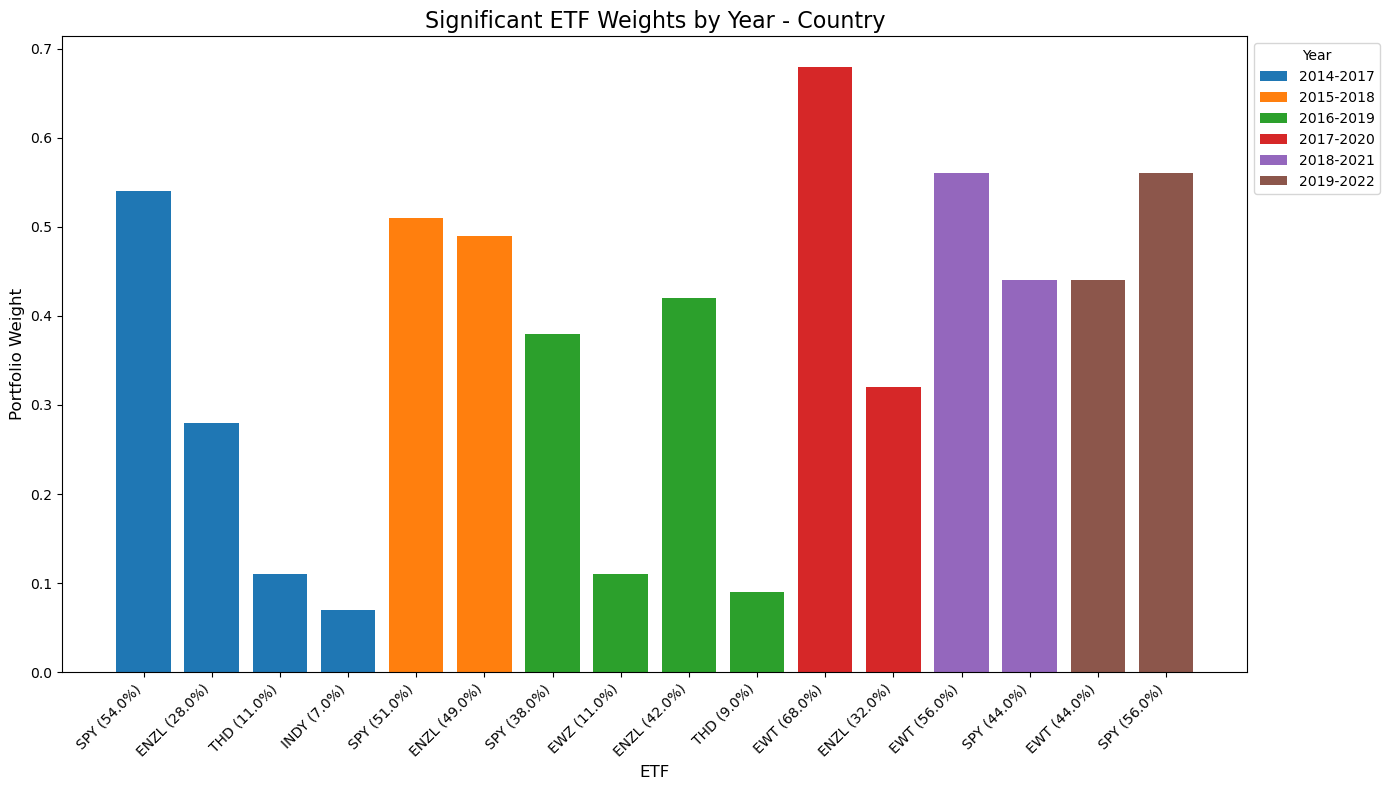

In [13]:
threshold = 0.00001
fig, ax = plt.subplots(figsize=(14, 8))

#START: Code created by AI

# Iterate over periods and plot significant ETF weights
for result in summary_results:
    period = result["Period"]
    significant_etfs = {
        etf: weight for etf, weight in result["Significant ETFs"].items() if weight > threshold
    }   #END: Code created by AI

    if significant_etfs:
        labels, weights = zip(*significant_etfs.items())
        x_positions = [f"{label} ({weight * 100:.1f}%)" for label, weight in significant_etfs.items()]
        ax.bar(x_positions, weights, label=period)

# Plot details
ax.set_title("Significant ETF Weights by Year - Country", fontsize=16)
ax.set_xlabel("ETF", fontsize=12)
ax.set_ylabel("Portfolio Weight", fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.legend(title="Year", loc="upper left", bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()


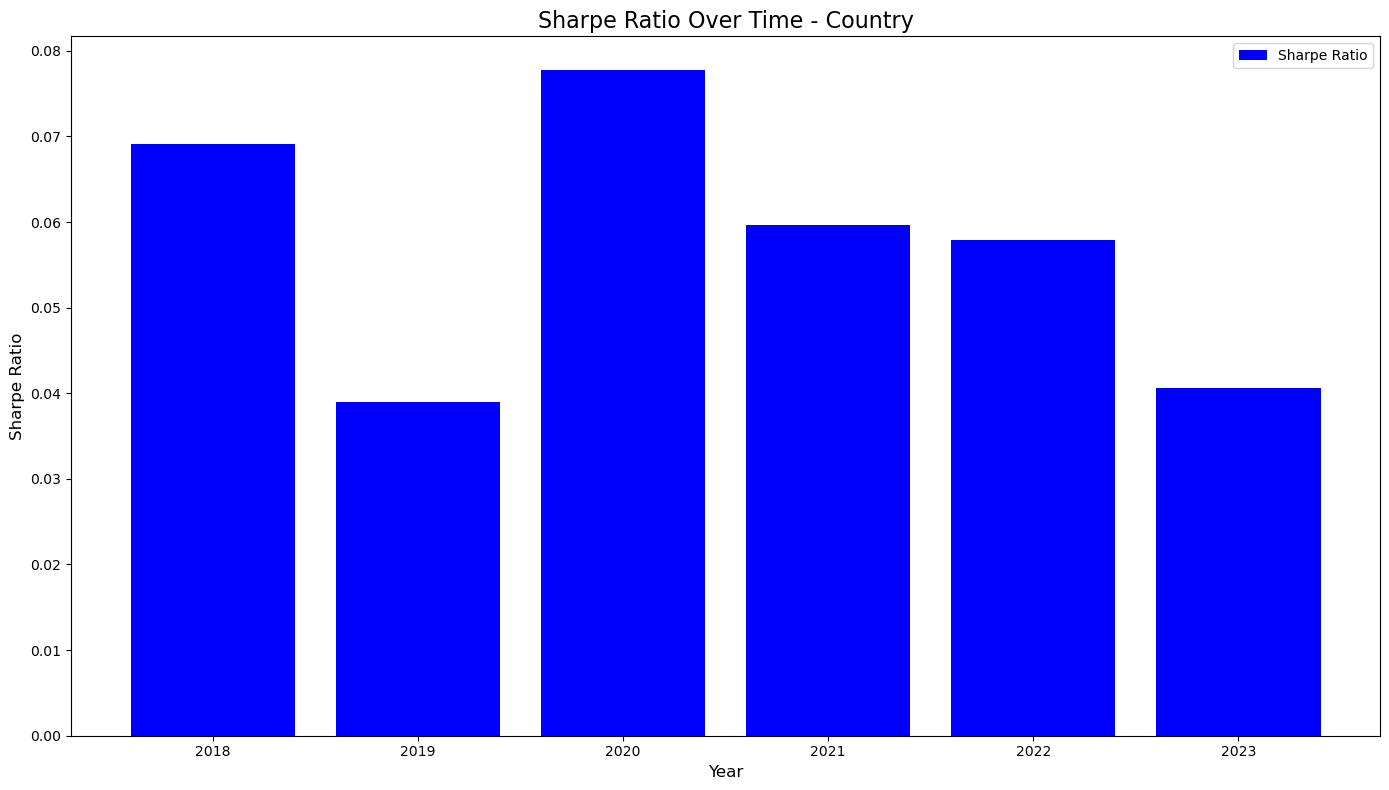

In [14]:
# Plotting Sharpe Ratio Over Time
sharpe_ratios = [res["Sharpe Ratio"] for res in summary_results]

fig, ax = plt.subplots(figsize=(14, 8))

ax.bar(investment_years, sharpe_ratios, color="blue", label="Sharpe Ratio")

# Configure plot aesthetics for Sharpe Ratio
ax.set_title("Sharpe Ratio Over Time - Country", fontsize=16)
ax.set_xlabel("Year", fontsize=12)
ax.set_ylabel("Sharpe Ratio", fontsize=12)
ax.legend()
plt.tight_layout()
plt.show()


# PART 4 Quarterly Portfolio Performance Analysis
#### Analyzes tangency portfolio returns, weights, and cumulative/quarterly performance across investment periods, with visualization of key metrics.

In [15]:
# Parameters
rolling_window = 4
start_year = 2014

In [16]:
# 3 month rolling
def next_quarter(start_date):
    """
    Calculate the start and end date of the next quarter.

    Args:
        start_date (str): Date string in the format "YYYY-MM-DD".

    Returns:
        tuple: Next quarter start and end date as strings in the format "YYYY-MM-DD".
    """
    year, month, _ = map(int, start_date.split('-'))

    # Determine the next quarter based on the current month
    if month == 1:
        return f"{year}-04-01", f"{year}-06-30"
    elif month == 4:
        return f"{year}-07-01", f"{year}-09-30"
    elif month == 7:
        return f"{year}-10-01", f"{year}-12-31"
    elif month == 10:
        return f"{year + 1}-01-01", f"{year + 1}-03-31"
    else:
        raise ValueError(f"Invalid month in start_date: {start_date}")

In [17]:
#START: Code created by AI

def get_last_day_of_month(year, month):
    """
    Returns the last day of a specified month and year.

    Args:
        year (int): The year of interest.
        month (int): The month of interest (1-12).

    Returns:
        str: The last day of the month in 'YYYY-MM-DD' format.
    """
    if month in {1, 3, 5, 7, 8, 10, 12}:
        return f"{year}-{month:02d}-31"
    elif month in {4, 6, 9, 11}:
        return f"{year}-{month:02d}-30"
    else:
        return f"{year}-{month:02d}-28"  # February (non-leap year for simplicity)

#END: Code created by AI


In [18]:
# Tangency Portfolio calculation with quarterly rebalancing
quarterly_results = []
current_rolling_start_date = f"{start_year}-01-01"
investment_start_date = "2018-01-01"

while True:
    # Rolling period (4 anni)
    rolling_end_date = pd.to_datetime(current_rolling_start_date) + pd.DateOffset(years=rolling_window, months=-1)
    rolling_end_date = rolling_end_date.strftime("%Y-%m-%d")

    # Determines the last day of the month for the rolling period
    rolling_end_date_parts = rolling_end_date.split('-')
    year, month = int(rolling_end_date_parts[0]), int(rolling_end_date_parts[1])
    rolling_end_date = get_last_day_of_month(year, month)

    #START: Code created by AI
        
    if int(rolling_end_date.split('-')[0]) > 2023:
        break

    rolling_data = country_data.loc[current_rolling_start_date:rolling_end_date]

    # Computation of average returns and covariance matrix
    mean_returns = rolling_data.mean().values
    cov_matrix = rolling_data.cov().values

    # Tangency Portfolio
    tangency_weights = calculate_tangency_portfolio(mean_returns, cov_matrix)
    significant_etfs = {k: round(v, 2) for k, v in zip(country_indices.keys(), tangency_weights) if v > 0.001}
    tangency_return = np.dot(tangency_weights, mean_returns)
    tangency_risk = np.sqrt(np.dot(tangency_weights.T, np.dot(cov_matrix, tangency_weights)))
    sharpe_ratio = (tangency_return) / tangency_risk

    # Investment period (3 months)
    investment_start_date_dt = pd.to_datetime(investment_start_date)
    investment_end_date_dt = investment_start_date_dt + pd.DateOffset(months=3) - pd.DateOffset(days=1)
    investment_start_date = investment_start_date_dt.strftime("%Y-%m-%d")
    investment_end_date = investment_end_date_dt.strftime("%Y-%m-%d")

    if int(investment_end_date.split('-')[0]) > 2023:
        break

    # Save results
    quarterly_results.append({
        "Rolling Period": f"{current_rolling_start_date} to {rolling_end_date}",
        "Investment Period": f"{investment_start_date} to {investment_end_date}",
        "Tangency Weights": significant_etfs,
        "Sharpe Ratio": round(sharpe_ratio, 4)
    })

    # Update the date
    current_rolling_start_date = next_quarter(current_rolling_start_date)[0]  # Advance 3 months in the rolling period
    investment_start_date = next_quarter(investment_start_date)[0]

    #END: Code created by AI

In [19]:
# Summary Table
print("\nSummary Table:\n")
summary_table = pd.DataFrame(quarterly_results)
summary_table.style.set_properties(**{'font-size': '12pt', 'text-align': 'center'})


Summary Table:



,Rolling Period,Investment Period,Tangency Weights,Sharpe Ratio
0,2014-01-01 to 2017-12-31,2018-01-01 to 2018-03-31,"{'SPY': 0.54, 'ENZL': 0.28, 'THD': 0.11, 'INDY': 0.07}",0.069100
1,2014-04-01 to 2018-03-31,2018-04-01 to 2018-06-30,"{'SPY': 0.66, 'ENZL': 0.22, 'THD': 0.13}",0.057700
2,2014-07-01 to 2018-06-30,2018-07-01 to 2018-09-30,"{'SPY': 0.74, 'ENZL': 0.26}",0.054200
3,2014-10-01 to 2018-09-30,2018-10-01 to 2018-12-31,"{'SPY': 0.7, 'ENZL': 0.3}",0.063400
4,2015-01-01 to 2018-12-31,2019-01-01 to 2019-03-31,"{'SPY': 0.51, 'ENZL': 0.49}",0.039000
5,2015-04-01 to 2019-03-31,2019-04-01 to 2019-06-30,"{'SPY': 0.51, 'EWZ': 0.0, 'ENZL': 0.49}",0.054000
6,2015-07-01 to 2019-06-30,2019-07-01 to 2019-09-30,"{'SPY': 0.35, 'ENZL': 0.65}",0.066600
7,2015-10-01 to 2019-09-30,2019-10-01 to 2019-12-31,"{'SPY': 0.38, 'EWZ': 0.06, 'ENZL': 0.55, 'THD': 0.02}",0.076500
8,2016-01-01 to 2019-12-31,2020-01-01 to 2020-03-31,"{'SPY': 0.38, 'EWZ': 0.11, 'ENZL': 0.42, 'THD': 0.09}",0.077800
9,2016-04-01 to 2020-03-31,2020-04-01 to 2020-06-30,"{'EWT': 0.28, 'SPY': 0.67, 'ENZL': 0.05}",0.028600


['2018-01-01', '2018-04-01', '2018-07-01', '2018-10-01', '2019-01-01', '2019-04-01', '2019-07-01', '2019-10-01', '2020-01-01', '2020-04-01', '2020-07-01', '2020-10-01', '2021-01-01', '2021-04-01', '2021-07-01', '2021-10-01', '2022-01-01', '2022-04-01', '2022-07-01', '2022-10-01', '2023-01-01', '2023-04-01', '2023-07-01', '2023-10-01']


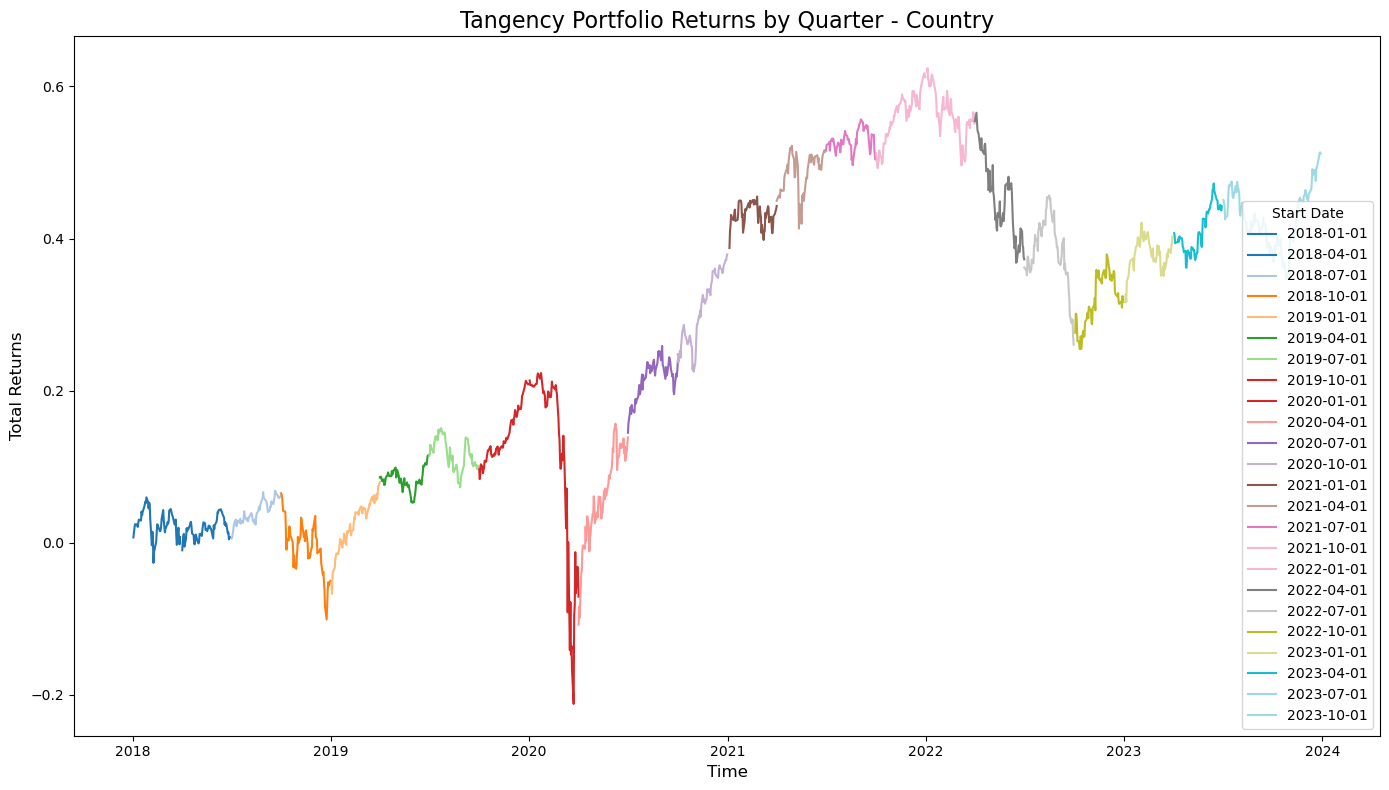

In [20]:
date_list = [f"{year}-{month:02d}-01" for year in range(2018, 2024) for month in [1, 4, 7, 10] if not (year == 2023 and month > 10)]

print(date_list)

cumulative_returns = [0]  # Start with 0 for the initial investment
colors = cm.tab20(np.linspace(0, 1, len(date_list)))

fig, ax = plt.subplots(figsize=(14, 8))

# Calculate cumulative and quarterly returns for each investment period
for idx, date in enumerate(date_list):
    # Determine the end of the quarter
    next_date_idx = idx + 1 if idx + 1 < len(date_list) else None
    investment_data = country_data.loc[date:date_list[next_date_idx]] if next_date_idx else country_data.loc[date:] #LINE created by AI

    # Get tangency portfolio weights from the previous rolling window
    tangency_weights = quarterly_results[idx % len(quarterly_results)]["Tangency Weights"]
    weights_array = np.array([tangency_weights.get(etf, 0) for etf in country_indices.keys()])

    # Calculate quarterly cumulative returns for the tangency portfolio
    quarterly_data = investment_data.dot(weights_array)
    quarterly_cumulative = cumulative_returns[-1] + quarterly_data.cumsum()

    # Update cumulative returns and plot the series
    cumulative_returns.append(quarterly_cumulative.iloc[-1])
    ax.plot(quarterly_cumulative.index, quarterly_cumulative, label=f"{date}", color=colors[idx])

# Configure plot aesthetics
ax.set_title("Tangency Portfolio Returns by Quarter - Country", fontsize=16)
ax.set_xlabel("Time", fontsize=12)
ax.set_ylabel("Total Returns", fontsize=12)
ax.legend(title="Start Date")
plt.tight_layout()
plt.show()


In [21]:
quarterly_returns = np.diff(cumulative_returns)
for period, return_value in zip(date_list, quarterly_returns):
    print(f"Period {period}: Return = {return_value:.4f}")
print(f"Final Total Return: {cumulative_returns[-1]:.4f}")


Period 2018-01-01: Return = 0.0077
Period 2018-04-01: Return = -0.0005
Period 2018-07-01: Return = 0.0550
Period 2018-10-01: Return = -0.1120
Period 2019-01-01: Return = 0.1298
Period 2019-04-01: Return = 0.0358
Period 2019-07-01: Return = -0.0162
Period 2019-10-01: Return = 0.1090
Period 2020-01-01: Return = -0.2793
Period 2020-04-01: Return = 0.2093
Period 2020-07-01: Return = 0.1004
Period 2020-10-01: Return = 0.1402
Period 2021-01-01: Return = 0.0637
Period 2021-04-01: Return = 0.0726
Period 2021-07-01: Return = -0.0075
Period 2021-10-01: Return = 0.1040
Period 2022-01-01: Return = -0.0596
Period 2022-04-01: Return = -0.1798
Period 2022-07-01: Return = -0.1120
Period 2022-10-01: Return = 0.0560
Period 2023-01-01: Return = 0.0859
Period 2023-04-01: Return = 0.0399
Period 2023-07-01: Return = -0.0575
Period 2023-10-01: Return = 0.1269
Final Total Return: 0.5119


C:\Users\Asus\AppData\Local\Temp\ipykernel_5048\14473851.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha="right")


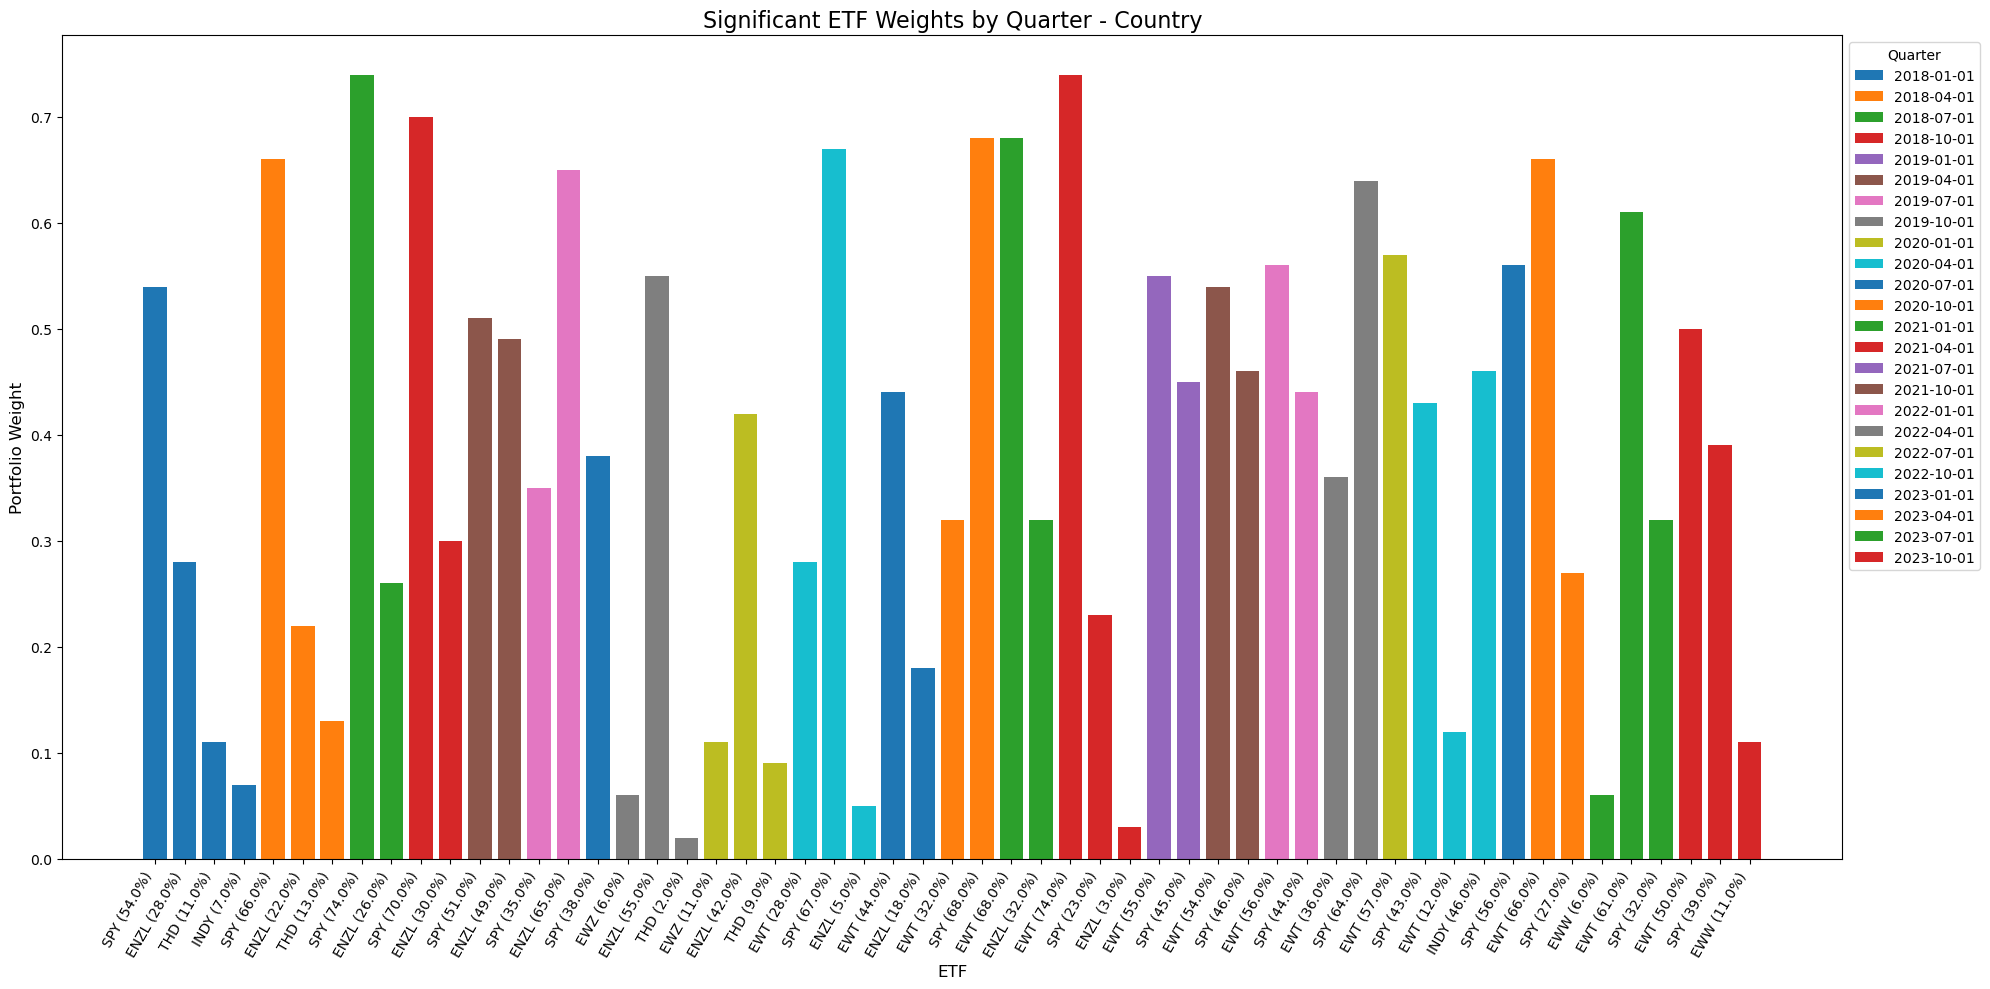

In [22]:
threshold = 0.00001
fig, ax = plt.subplots(figsize=(20, 10))

# Iterate over periods and plot significant ETF weights
for idx, result in enumerate(quarterly_results):
    period = date_list[idx]
    significant_etfs = {
        etf: weight for etf, weight in result["Tangency Weights"].items() if weight > threshold #Line created by AI
    }


    if significant_etfs:
        labels, weights = zip(*significant_etfs.items())
        x_positions = [f"{label} ({weight * 100:.1f}%)" for label, weight in significant_etfs.items()]
        ax.bar(x_positions, weights, label=period)

# Plot details
ax.set_title("Significant ETF Weights by Quarter - Country", fontsize=16)
ax.set_xlabel("ETF", fontsize=12)
ax.set_ylabel("Portfolio Weight", fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha="right")
ax.legend(title="Quarter", loc="upper left", bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()


C:\Users\Asus\AppData\Local\Temp\ipykernel_5048\2280314125.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha="right")


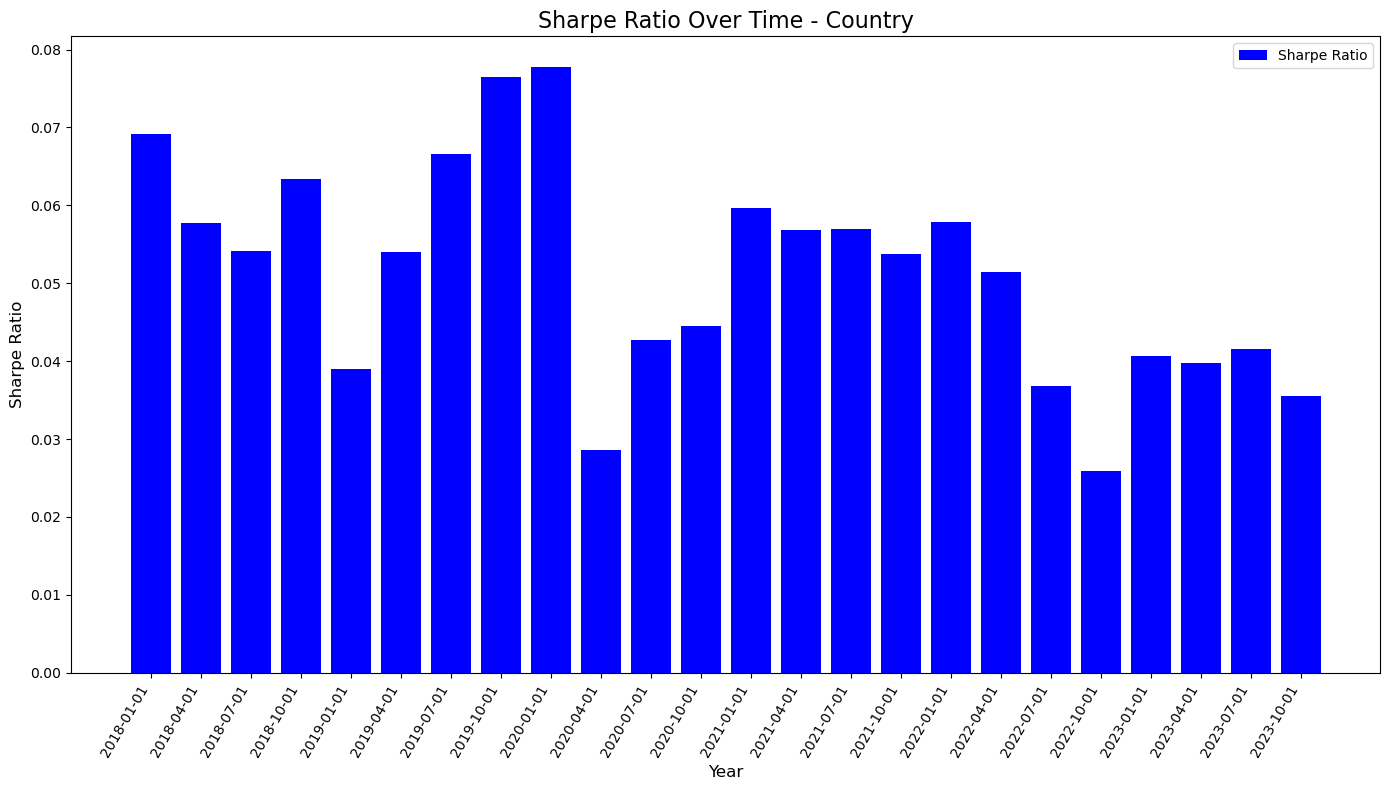

In [23]:
# Plotting Sharpe Ratio Over Time
sharpe_ratios = [res["Sharpe Ratio"] for res in quarterly_results]

fig, ax = plt.subplots(figsize=(14, 8))

ax.bar(date_list, sharpe_ratios, color="blue", label="Sharpe Ratio")

# Configure plot aesthetics for Sharpe Ratio
ax.set_title("Sharpe Ratio Over Time - Country", fontsize=16)
ax.set_xlabel("Year", fontsize=12)
ax.set_ylabel("Sharpe Ratio", fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha="right")
ax.legend()
plt.tight_layout()
plt.show()